## Modeling Water Pump Data

In [28]:
#Imports:
import pandas as pd
import requests
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn import set_config
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer 
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, balanced_accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import PartialDependenceDisplay

import warnings
warnings.filterwarnings('ignore') 

#####

In [2]:
df = pd.read_csv('../data_sb/og_water_data.csv')
target = pd.read_csv('../data_sb/og_water_target.csv')
sub_test = pd.read_csv('../data_sb/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')

In [3]:
df_joined = pd.concat([df,target], axis=1)

##### General proportions of functional/non funtional/functional needs repair for Iringa:

In [4]:
df_joined[df_joined['region'] == 'Iringa']['status_group'].value_counts(normalize=True)

functional                 0.782206
non functional             0.194560
functional needs repair    0.023234
Name: status_group, dtype: float64

##### DF quick descriptive stats:

In [5]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [6]:
len(target['status_group']), len(df['id'])

(59400, 59400)

#### Baseline Accuracy (54.3%)

In [30]:
df_joined['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

##### Temp split for logreg coef interpretation analysis of numerical features only:

In [8]:
X1 = df_joined.drop(columns = ['basin','region','lga','public_meeting','recorded_by',
                         'scheme_management','permit','extraction_type','management','management_group','payment',
                         'water_quality','quality_group','quantity','source','waterpoint_type','subvillage','installer',
                              'funder','ward','scheme_name','wpt_name','waterpoint_type_group','extraction_type_group',
                              'payment_type','quantity_group','source_type','source_class','extraction_type_class','id', 
                              'status_group' , 'longitude' , 'latitude' , 'date_recorded', 'region_code', 'district_code'])
y1 = df_joined['status_group']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, stratify = y1, random_state=123)

##### Temp LR model for interpretability of numerical features:

In [9]:
lr1 = LogisticRegression(max_iter=10000)
lr1.fit(X_train1,y_train1)
lr1.score(X_train1,y_train1),lr1.score(X_test1,y_test1)

(0.5396857463524131, 0.5451851851851852)

In [10]:
lr1.coef_

array([[ 1.04501428e-04,  1.65809513e-04,  1.04298535e-03,
         1.53629928e-05, -2.93720515e-06],
       [ 7.98957779e-05,  7.57638614e-05, -1.09649406e-03,
         5.34643636e-05, -1.43458570e-04],
       [-1.84397207e-04, -2.41573374e-04,  5.35087085e-05,
        -6.88273564e-05,  1.46395776e-04]])

##### Creating numerical df coefficient dataframe:

In [11]:
numerical_coef_df = pd.DataFrame(np.exp(lr1.coef_).T)
numerical_coef_df['features'] = list(X_train1.columns)
numerical_coef_df = numerical_coef_df.set_index('features')
numerical_coef_df.sort_values(by=[0],ascending=True)

,0,1,2
features,,,
construction_year,0.999997,0.999857,1.000146
population,1.000015,1.000053,0.999931
amount_tsh,1.000105,1.000080,0.999816
gps_height,1.000166,1.000076,0.999758
num_private,1.001044,0.998904,1.000054


#### Partial dependence  plots for exploratory logistic regression model with numerical features only:

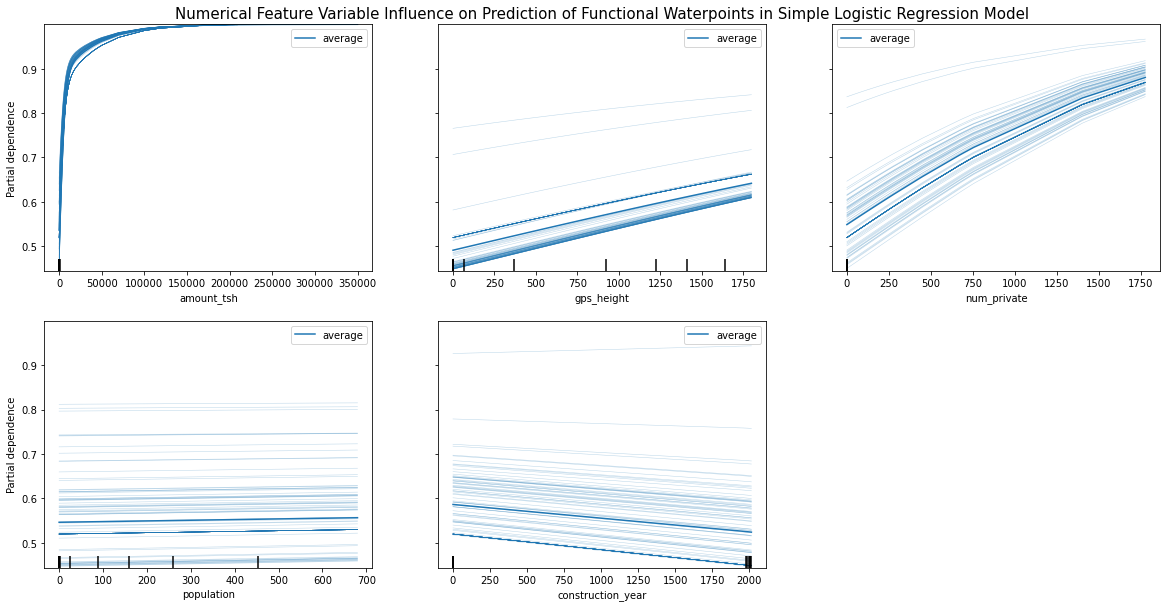

In [249]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Numerical Feature Variable Influence on Prediction of Functional Waterpoints in Simple Logistic Regression Model", fontsize=15)
pdd = PartialDependenceDisplay.from_estimator(lr1, X_train1, target='functional', features=[0,1,2,3,4], subsample=100, kind='both',n_jobs=-1, ax=ax);
plt.savefig('./visualizations_sb/pdd_numeric_func.png', transparent=True, bbox_inches = 'tight')

- This partial dependence plot show that as num_private and a water points gps height increase, so does the likelihood of being a functional well.
- The year of construction appear to negatively correlate with functionality.
- Population has almost no weight on functionality prediction. 

#### Partial dependence  plots for exploratory logistic regression model with numerical features only:

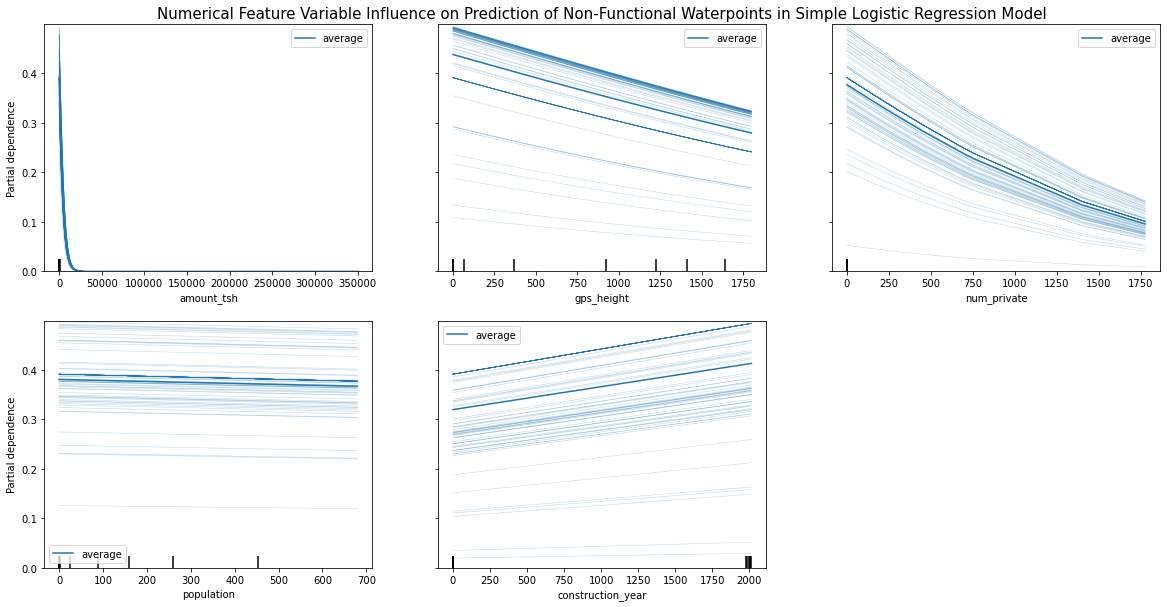

In [250]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Numerical Feature Variable Influence on Prediction of Non-Functional Waterpoints in Simple Logistic Regression Model", fontsize=15)
pdd = PartialDependenceDisplay.from_estimator(lr1, X_train1, target='non functional', features=[0,1,2,3,4], subsample=100, kind='both',n_jobs=-1, ax=ax);
plt.savefig('./visualizations_sb/pdd_numeric_nonfunc.png', transparent=True, bbox_inches = 'tight')

- This partial dependence plot show that as num_private and a water points gps height decrease, so does the likelihood of being a non-functional well.
- The year of construction also appears to positively correlate with non-functionality.
- Population has almost no weight on functionality prediction. 

#### Partial dependence  plots for exploratory logistic regression model with numerical features only:

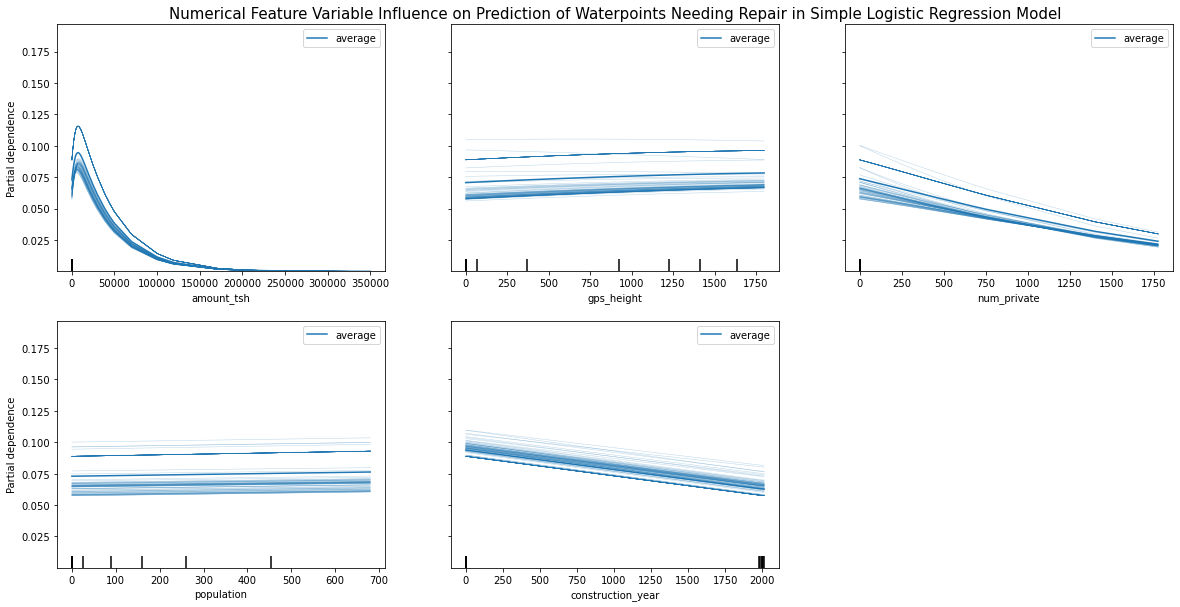

In [251]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Numerical Feature Variable Influence on Prediction of Waterpoints Needing Repair in Simple Logistic Regression Model", fontsize=15)
pdd = PartialDependenceDisplay.from_estimator(lr1, X_train1, target='functional needs repair', features=[0,1,2,3,4], subsample=100, kind='both',n_jobs=-1, ax=ax);
plt.savefig('./visualizations_sb/pdd_numeric_repair.png', transparent=True, bbox_inches = 'tight')

- This partial dependence plot show that as construction year and a water point gps height decreases, so does the likelihood of being a functional water point in need of repair.
- Population and gps height appear to have almost no weight on predicting water points in need of repair. 

#### Temp split for logreg coef interpretation analysis of 251 feature set only:

In [12]:
X = df_joined.drop(columns = ['subvillage','installer','funder','ward','scheme_name','wpt_name','waterpoint_type_group','extraction_type_group','payment_type','quantity_group','source_type','source_class','extraction_type_class','id', 'status_group' , 'longitude' , 'latitude' , 'date_recorded'])
y = df_joined['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=123)

ct1 = ColumnTransformer([('si',SimpleImputer(strategy='constant'),
                          ['public_meeting','scheme_management','permit']),],
                         remainder='passthrough',verbose_feature_names_out = False)            

train_si = ct1.fit_transform(X_train)
train_si = pd.DataFrame(train_si, columns=X_train.columns)
test_si = ct1.transform(X_test)
test_si = pd.DataFrame(test_si, columns=X_test.columns)
sub_test_si = ct1.transform(sub_test)
sub_test_si = pd.DataFrame(sub_test_si, columns=X_test.columns)


ct2 = ColumnTransformer([('ohe',OneHotEncoder(drop='if_binary',handle_unknown='ignore',sparse=False),
                        ['basin','region','lga','public_meeting','recorded_by',
                         'scheme_management','permit','extraction_type','management','management_group','payment',
                         'water_quality','quality_group','quantity','source','waterpoint_type'])],
                         remainder='passthrough',verbose_feature_names_out = False)  


##### Encoding categorical variables for temp interpretation model:

In [13]:
train_enc = ct2.fit_transform(X_train)
train_enc = pd.DataFrame(train_enc, columns = ct2.get_feature_names_out())
test_enc = ct2.transform(X_test)
test_enc = pd.DataFrame(test_enc, columns = ct2.get_feature_names_out())
sub_test_enc = ct2.transform(sub_test)
sub_test_enc = pd.DataFrame(sub_test_enc, columns = ct2.get_feature_names_out())

##### Standard Scaler for temp interpretation model:

In [14]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(train_enc)
X_train_sc = pd.DataFrame(X_train_sc, columns = ss.get_feature_names_out())
X_test_sc = ss.transform(test_enc)
X_test_sc = pd.DataFrame(X_test_sc, columns = ss.get_feature_names_out())
sub_test_sc = ss.transform(sub_test_enc)
sub_test_sc = pd.DataFrame(sub_test_sc, columns = ss.get_feature_names_out())

#### Temp LR model for interpretability of numerical features:

In [207]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_sc,y_train)
lr.score(X_train_sc,y_train),lr.score(X_test_sc,y_test)

(0.753557800224467, 0.7412794612794613)

##### Creating df of categorical coefficient:

In [208]:
coef_df = pd.DataFrame(np.exp(lr.coef_).T)
coef_df['features'] = list(X_train_sc.columns)
coef_df = coef_df.set_index('features')
coef_df.sort_values(by=[1],ascending=False)[:50]

,0,1,2
features,,,
lga_Bariadi,0.886353,1.311771,0.860073
gps_height,1.014575,1.199627,0.821617
lga_Masasi,0.916898,1.173804,0.929144
lga_Ngara,0.987315,1.166715,0.868120
source_river,0.927254,1.161569,0.928446
lga_Bukombe,0.936245,1.160037,0.920744
lga_Dodoma Urban,0.988435,1.155734,0.875375
lga_Mpanda,0.893754,1.145278,0.976948
extraction_type_gravity,0.919668,1.142978,0.951330


##### Code for inspecting this dataframe for most/least weighted coefs:

In [209]:
coef_df.sort_values(by=[1],ascending=True)[:50]

,0,1,2
features,,,
lga_Makete,1.241151,0.685040,1.176141
lga_Hanang,1.155502,0.749624,1.154479
quantity_dry,0.562324,0.759329,2.341983
lga_Kongwa,1.263372,0.761552,1.039368
lga_Muheza,1.198449,0.766607,1.088447
lga_Sengerema,1.133344,0.778785,1.132976
lga_Chato,1.091729,0.781058,1.172741
lga_Bagamoyo,1.144330,0.790297,1.105754
lga_Ilala,1.106989,0.799625,1.129719


#### Partial dependence  plots for exploratory logistic regression model with regions encoded:

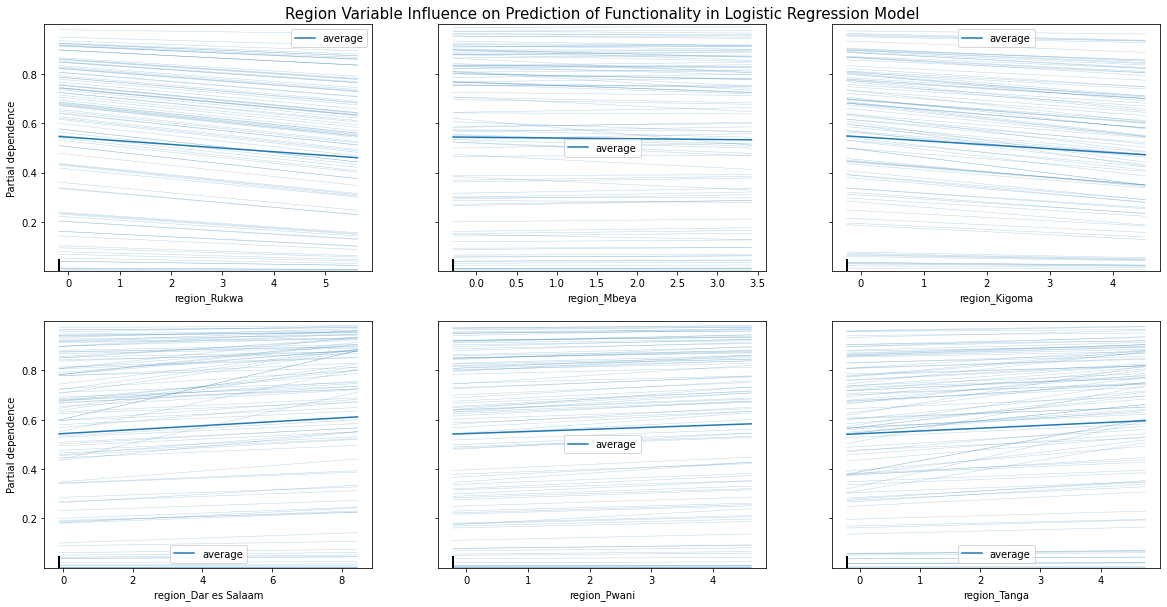

In [253]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Region Variable Influence on Prediction of Functionality in Logistic Regression Model", fontsize=15)
pdd = PartialDependenceDisplay.from_estimator(lr, X_train_sc, target='functional', features=[24,19,14,10, 23, 29], subsample=100, kind='both',n_jobs=-1, ax=ax);
plt.savefig('./visualizations_sb/pdd_region_func.png', transparent=True, bbox_inches = 'tight')

- This plot singles out encoded region variables with the largest and smallest precipitation ranges from year to year. 
- Regions with less range of precipitation show negative correlation with functionality.
- Regions with more range of precipitation show positive correlation with functionality.

#### Searching for best model:

In [15]:
X2 = df_joined.drop(columns = ['permit','subvillage','funder','wpt_name','waterpoint_type_group','extraction_type_group',
                               'payment_type','quantity_group','source_type','source_class','extraction_type_class','id',
                               'status_group' , 'longitude' , 'latitude' , 'date_recorded'])
y2 = df_joined['status_group']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify = y, random_state=123)

ct1_1 = ColumnTransformer([('si',SimpleImputer(strategy='constant'),
                          ['public_meeting','scheme_management','scheme_name','installer']),],
                         remainder='passthrough',verbose_feature_names_out = False)  
        
train_si2 = ct1_1.fit_transform(X_train2)
train_si2 = pd.DataFrame(train_si2, columns=['public_meeting','scheme_management','scheme_name','installer',
                                             'amount_tsh', 'gps_height', 'num_private', 'basin',
                                           'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
                                            'recorded_by', 'construction_year', 'extraction_type', 'management',
                                            'management_group', 'payment', 'water_quality', 'quality_group',
                                               'quantity', 'source', 'waterpoint_type'])
test_si2 = ct1_1.transform(X_test2)
test_si2 = pd.DataFrame(test_si2, columns=['public_meeting','scheme_management','scheme_name','installer',
                                             'amount_tsh', 'gps_height', 'num_private', 'basin',
                                           'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
                                            'recorded_by', 'construction_year', 'extraction_type', 'management',
                                            'management_group', 'payment', 'water_quality', 'quality_group',
                                               'quantity', 'source', 'waterpoint_type'])

ct2_2 = ColumnTransformer([('ohe',OneHotEncoder(drop='if_binary',handle_unknown='ignore',sparse=False),
                        ['basin','region','lga','ward','public_meeting','recorded_by','scheme_name','installer',
                         'scheme_management','extraction_type','management','management_group','payment',
                         'water_quality','quality_group','quantity','source','waterpoint_type'])],
                         remainder='passthrough',verbose_feature_names_out = False) 

##### Encoding train/test to find best model:

In [16]:
train_enc2 = ct2_2.fit(X_train2)
train_enc2 = pd.DataFrame(ct2_2.transform(X_train2))
test_enc2 = pd.DataFrame(ct2_2.transform(X_test2))

##### Encoding submission test set to find best model:

In [17]:
sub_test_enc2 = ct2_2.transform(sub_test)
sub_test_enc2 = pd.DataFrame(sub_test_enc2, columns = ct2_2.get_feature_names_out())

##### Standard Scaling train/test to find best model:

In [18]:
ss2 = StandardScaler()
X_train_sc2 = ss.fit_transform(train_enc2)
X_train_sc2 = pd.DataFrame(X_train_sc2)
X_test_sc2 = ss.transform(test_enc2)
X_test_sc2 = pd.DataFrame(X_test_sc2)

##### Standard Scaling submission test set to find best model:

In [19]:
sub_test_sc2 = ss.transform(sub_test_enc2)
sub_test_sc2 = pd.DataFrame(sub_test_sc2)

#### Best performing model 1 for submission attempt:

In [32]:
rfc = RandomForestClassifier()
rfc.fit(X_train_sc,y_train)
rfc.score(X_train_sc,y_train),rfc.score(X_test_sc,y_test)

(0.9443097643097643, 0.7863299663299663)

#### Best performing model 2 for submission attempt:

In [33]:
rfc2 = RandomForestClassifier()
rfc2.fit(X_train_sc2,y_train)
rfc2.score(X_train_sc2,y_train),rfc2.score(X_test_sc2,y_test)

(0.9669809203142536, 0.7908417508417508)

#### Preparing and saving submission 1:

In [34]:
sub_preds = rfc.predict(sub_test_sc)
submission = pd.DataFrame()
submission.index = sub_test['id'].copy()
submission['status_group'] = sub_preds
submission
submission.to_csv('../submissions/submission_01.csv')

#### Preparing and saving submission 2:

In [35]:
sub_preds2 = rfc2.predict(sub_test_sc2)
submission2 = pd.DataFrame()
submission2.index = sub_test['id'].copy()
submission2['status_group'] = sub_preds2
submission2.to_csv('../submissions/submission_02.csv')

### Trying More Models

In [2]:
X = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv")
y = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv")
X.shape, y.shape

((59400, 40), (59400, 2))

In [44]:
X["datetime_recorded"] = pd.to_datetime(X["date_recorded"])
#356 different values

In [564]:
X["datetime_recorded"].dt.year.value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: datetime_recorded, dtype: int64

In [45]:
X["year_month_recorded"] = X["datetime_recorded"].dt.to_period('M').dt.strftime("%Y-%m")
#keep only year and month
#reduce to 38 different values

In [46]:
#w/out date_recorded, less features, run faster, acc = 74.8%
cat_feats = ["region",
             "lga",
             "public_meeting",
             "scheme_management",
             "permit",
             "extraction_type",
             "management",
             "payment_type",
             "water_quality",
             "quantity_group",
             "source",
             "waterpoint_type",
             "date_recorded"]

In [47]:
X_cat = X[cat_feats]
X_cat.isna().sum()

region                  0
lga                     0
public_meeting       3334
scheme_management    3877
permit               3056
extraction_type         0
management              0
payment_type            0
water_quality           0
quantity_group          0
source                  0
waterpoint_type         0
date_recorded           0
dtype: int64

In [48]:
X_cat.shape

(59400, 13)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, random_state=42, stratify=y)

#### Logistic Regression

> ##### SimpleImputer

In [50]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe1 = Pipeline([("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe1.fit(X_train, y_train)
pipe1.score(X_train, y_train).round(3), pipe1.score(X_test, y_test).round(3)

(0.756, 0.753)

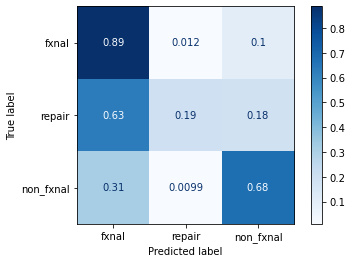

In [51]:
ConfusionMatrixDisplay.from_estimator(pipe1,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

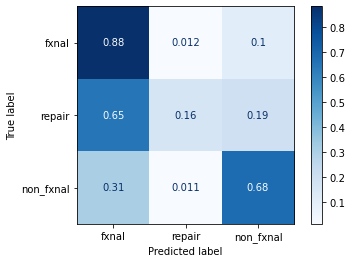

In [52]:
ConfusionMatrixDisplay.from_estimator(pipe1,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

> Poor performance on the "repair" class
>
> Maybe use techniques for imbalanced data

##### KNNImputer (Same Performance as SimpleImputer)

In [53]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

knn_imputer = KNNImputer(n_neighbors=15)

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe2 = Pipeline([("ohe", mct), ("impu", knn_imputer), ("sc", ss), ("clf", logreg)])

pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train).round(3), pipe2.score(X_test, y_test).round(3)

(0.756, 0.753)

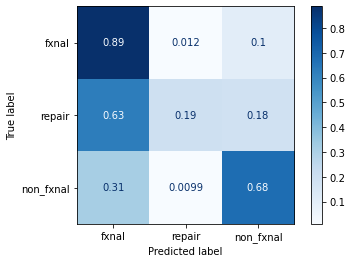

In [54]:
ConfusionMatrixDisplay.from_estimator(pipe2,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

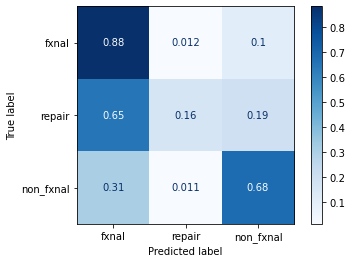

In [55]:
ConfusionMatrixDisplay.from_estimator(pipe2,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

##### Include 9 Numeric Features (No Difference)

In [56]:
num_feats = list(X.select_dtypes(include = "number").drop(columns = ["id"]).columns)
#list of numeric features

In [57]:
X_num_cat = X[num_feats + cat_feats]

In [58]:
X_num_cat.shape

(59400, 22)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, random_state=42, stratify=y)

In [60]:
ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe3 = Pipeline([("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe3.fit(X_train, y_train)
pipe3.score(X_train, y_train).round(3), pipe3.score(X_test, y_test).round(3)

(0.756, 0.753)

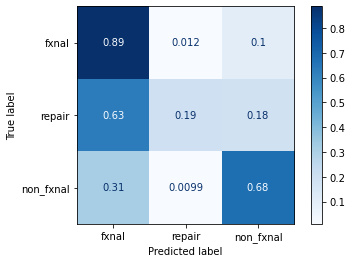

In [61]:
ConfusionMatrixDisplay.from_estimator(pipe3,
                                      X_train,
                                      y_train,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

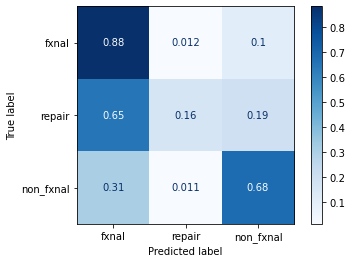

In [62]:
ConfusionMatrixDisplay.from_estimator(pipe3,
                                      X_test,
                                      y_test,
                                      cmap ="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize="true");

> The 9 numeric features are not useful for prediction

#### Modeling with Imbalanced Data

In [430]:
cat_feats = ["region",
             "lga",
             "public_meeting",
             "scheme_management",
             "permit",
             "extraction_type",
             "management",
             "payment_type",
             "water_quality",
             "quantity_group",
             "source",
             "waterpoint_type"]

In [431]:
X_cat = X[cat_feats]
X_cat.isna().sum()

region                  0
lga                     0
public_meeting       3334
scheme_management    3877
permit               3056
extraction_type         0
management              0
payment_type            0
water_quality           0
quantity_group          0
source                  0
waterpoint_type         0
dtype: int64

In [432]:
X_cat.shape

(59400, 12)

In [433]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, random_state=42, stratify=y)

#### Oversampling to Fully Balanced Data

In [450]:
#Over sampling to make all classes have the same population. This is extreme.
ros = RandomOverSampler(random_state=42,
                        sampling_strategy="not majority")

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe5 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

# gs5 = GridSearchCV(pipe5,
#                    {"ros__sampling_strategy": [0.25, 0.5, 0.75, 1.0]},
#                    scoring="balanced_accuracy", 
#                    n_jobs=-1)
# gs5.fit(X_train, y_train)

pipe5.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='not majority')),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality',
              

In [461]:
pipe5.score(X_train, y_train).round(3), pipe5.score(X_test, y_test).round(3)

(0.651, 0.652)

In [462]:
balanced_accuracy_score(y_test, pipe5.predict(X_test)).round(3)

0.665

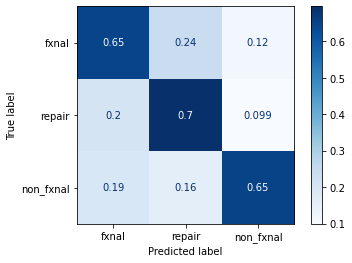

In [454]:
ConfusionMatrixDisplay.from_estimator(pipe5,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

In [456]:
y_train.value_counts()

functional                 24194
non functional             17118
functional needs repair     3238
Name: status_group, dtype: int64

#### Oversample the Least Populated Class to 10,000 Observations 

In [457]:
#resample the least populated class (funtional needs repair) to 10_000 observations (up from 3_238)
ros = RandomOverSampler(random_state=42,
                        sampling_strategy={"functional needs repair": 10_000})

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe6 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe6.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy={'functional needs repair': 10000})),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_qual

In [463]:
pipe6.score(X_train, y_train).round(3), pipe6.score(X_test, y_test).round(3)

(0.723, 0.723)

In [464]:
balanced_accuracy_score(y_test, pipe6.predict(X_test)).round(3)

0.631

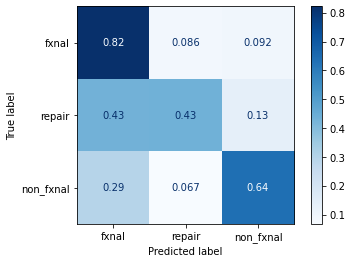

In [469]:
ConfusionMatrixDisplay.from_estimator(pipe6,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

#### Oversample the Least Populated Class to 15,000 Observations 

In [470]:
#resample the least populated class (funtional needs repair) to 15_000 observations (up from 3_238)
ros = RandomOverSampler(random_state=42,
                        sampling_strategy={"functional needs repair": 15_000})

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe7 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe7.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy={'functional needs repair': 15000})),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_qual

In [471]:
pipe7.score(X_train, y_train).round(3), pipe7.score(X_test, y_test).round(3)

(0.693, 0.697)

In [472]:
balanced_accuracy_score(y_test, pipe7.predict(X_test)).round(3)

0.658

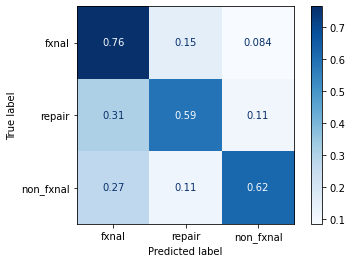

In [474]:
ConfusionMatrixDisplay.from_estimator(pipe7,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

#### Oversample the Least Populated Class to 20,000 Observations 

In [475]:
#resample the least populated class (funtional needs repair) to 20_000 observations (up from 3_238)
ros = RandomOverSampler(random_state=42,
                        sampling_strategy={"functional needs repair": 20_000})

ohe = OneHotEncoder(drop = "if_binary", sparse = False, handle_unknown="ignore")
mct = make_column_transformer((ohe, cat_feats), remainder="passthrough", verbose_feature_names_out=False)

si = SimpleImputer(strategy="most_frequent")

ss = StandardScaler()
logreg = LogisticRegression(max_iter=10_000)

pipe8 = ImbPipeline([ ("ros", ros), ("ohe", mct), ("impu", si), ("sc", ss), ("clf", logreg)])

pipe8.fit(X_train, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy={'functional needs repair': 20000})),
                ('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_qual

In [476]:
pipe8.score(X_train, y_train).round(3), pipe8.score(X_test, y_test).round(3)

(0.664, 0.667)

In [477]:
balanced_accuracy_score(y_test, pipe8.predict(X_test)).round(3)

0.663

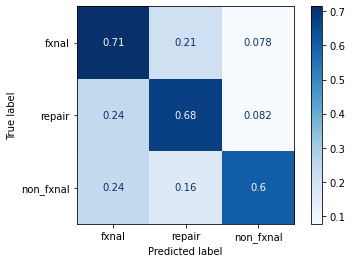

In [478]:
ConfusionMatrixDisplay.from_estimator(pipe8,
                                      X_test,
                                      y_test,
                                      cmap="Blues",
                                      display_labels=["fxnal", "repair", "non_fxnal"],
                                      normalize = "true");

## Conclusions and Recommendations